In [31]:
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

import sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split


from keras.models import Sequential, Model
from keras.layers import Cropping2D
from keras.layers import Flatten, Dense, Dropout, Lambda
from keras.layers import Conv2D
from keras.layers.convolutional import Convolution2D

from keras.layers.advanced_activations import ELU
from keras.optimizers import Adam

LEARNING_RATE = .0001
EPOCHS = 5 # 5ish seems like a sweet spot before validation loss stop declining 
BATCH_SIZE = 32
MODEL_FILE = 'model.h5'
STEERING_CORRECTION = 0.28
SAMPLE_DATA = './sampledata/'
DATA = './data/'

class DrivingData:
    image = None
    angle = 0.0
    directory = None
    flip = False

    def __init__(self, image, angle, flip, directory):
        self.image = image
        self.angle = angle
        self.directory = directory
        self.flip = flip

def flip_image(image, angle):
    flipped_image = np.fliplr(image)
    flipped_angle = angle * -1.0
    return flipped_image, flipped_angle

# Used by Keras to load data by batches 
def generator(samples, batch_size=32):
    num_samples = len(samples)

    while 1: # Loop forever so the generator never terminates
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                current_path = batch_sample.directory+'IMG/'+ batch_sample.image
                image = cv2.imread(current_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                angle = batch_sample.angle
                
                if batch_sample.flip:
                    image, angle = flip_image(image, angle)
                    
                images.append(image)
                angles.append(angle)

            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)
            
            
# Model used is based on NVIDIA as described at
# https://arxiv.org/abs/1604.07316
def get_model():
    model = Sequential()
    model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
    model.add(Cropping2D(cropping=((60,25),(0,0))))
    
    model.add(Conv2D(24, (5, 5), strides=(2, 2), activation="relu"))
    model.add(Conv2D(36, (5, 5), strides=(2, 2), activation="relu"))
    model.add(Conv2D(48, (5, 5), strides=(2, 2), activation="relu"))

    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(Conv2D(64, (3, 3), activation="relu"))

    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dropout(0.5))
    model.add(Dense(50))
    model.add(Dropout(0.5))
    model.add(Dense(10))
    model.add(Dense(1))

    model.summary()

    # Using the ADAM optimizer with a custom starting learning rate
    optimizer = Adam(lr=LEARNING_RATE)

    model.compile(loss='mse', optimizer=optimizer)

    return model

    



def main():
    samples = []
    
    # load sample data
#     directory = SAMPLE_DATA
#     with open(directory+'driving_log.csv') as csvfile:
#         reader = csv.reader(csvfile)
#         for line in reader:
#             # store center image driving data
#             name = line[0].split('/')[-1]
#             angle = float(line[3])
#             flip = False
            
#             # flip the set the images
#             #if np.random.uniform() > 0.5:
#             #    flip = True
                
#             samples.append(DrivingData(name, angle, flip, directory))
            
#             # also store left and right images with corrected steering angles
#             correction = STEERING_CORRECTION
#             angle_left = angle + correction
#             angle_right = angle - correction
            
#             name_left = line[1].split('/')[-1]
#             name_right = line[2].split('/')[-1]
            
            
#             samples.append(DrivingData(name_left, angle_left, flip, directory))
#             samples.append(DrivingData(name_right, angle_right, flip, directory))
            
#             # add flipped versions
#             flip = True
#             samples.append(DrivingData(name, angle, flip, directory))
#             samples.append(DrivingData(name_left, angle_left, flip, directory))
#             samples.append(DrivingData(name_right, angle_right, flip, directory))
            
    #load data - I am on a windows system which saves data in a different format
    directory = DATA
    with open(directory+'driving_log.csv') as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            # store center image driving data
            name = line[0].split('\\')[-1]
            angle = float(line[3])
            flip = False
            
            # flip the set the images
            #if np.random.uniform() > 0.5:
            #    flip = True
                
            samples.append(DrivingData(name, angle, flip, directory))
            
            # also store left and right images with corrected steering angles
#             correction = STEERING_CORRECTION
#             angle_left = angle + correction
#             angle_right = angle - correction
            
#             name_left = line[1].split('\\')[-1]
#             name_right = line[2].split('\\')[-1]
            
            
#             samples.append(DrivingData(name_left, angle_left, flip, directory))
#             samples.append(DrivingData(name_right, angle_right, flip, directory))
            
#             # add flipped versions
#             flip = True
#             samples.append(DrivingData(name, angle, flip, directory))
#             samples.append(DrivingData(name_left, angle_left, flip, directory))
#             samples.append(DrivingData(name_right, angle_right, flip, directory))

    print('Number of samples     : ', len(samples))

    from sklearn.model_selection import train_test_split
    train_samples, validation_samples = train_test_split(samples, test_size=0.2)
    
    print('Number of train samples     : ', len(train_samples))
    print('Number of validation samples: ', len(validation_samples))

    # compile and train the model using the generator function
    train_generator = generator(train_samples, batch_size=BATCH_SIZE)
    validation_generator = generator(validation_samples, batch_size=BATCH_SIZE)


    model = get_model()

    history_object = model.fit_generator(train_generator, steps_per_epoch =
        len(train_samples)/BATCH_SIZE, validation_data = 
        validation_generator,
        validation_steps = len(validation_samples)/BATCH_SIZE, 
        epochs=EPOCHS, verbose=1)
    
    ### print the keys contained in the history object
    print(history_object.history.keys())

    ### plot the training and validation loss for each epoch
    plt.plot(history_object.history['loss'])
    plt.plot(history_object.history['val_loss'])
    plt.title('model mean squared error loss')
    plt.ylabel('mean squared error loss')
    plt.xlabel('epoch')
    plt.legend(['training set', 'validation set'], loc='upper right')
    plt.show()


    print("Saving the model file=", MODEL_FILE)
    #Save the model
    model.save(MODEL_FILE)


if __name__ == "__main__":
    main()

Number of samples     :  9869
Number of train samples     :  7895
Number of validation samples:  1974
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_6 (Lambda)            (None, 160, 320, 3)       0         
_________________________________________________________________
cropping2d_6 (Cropping2D)    (None, 75, 320, 3)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 36, 158, 24)       1824      
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 77, 36)        21636     
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 6, 37, 48)         43248     
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 4, 35, 64)         27712     
________________________________________

KeyboardInterrupt: 

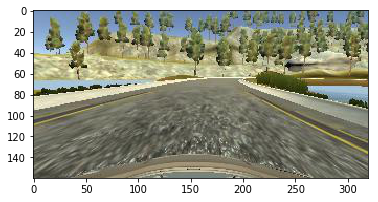

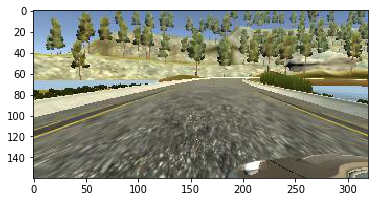

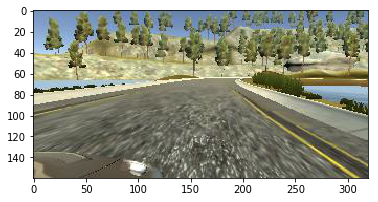

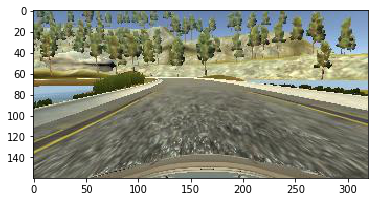

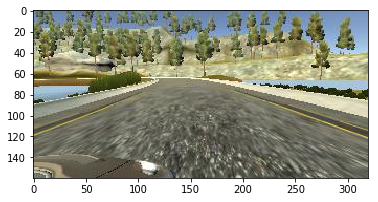

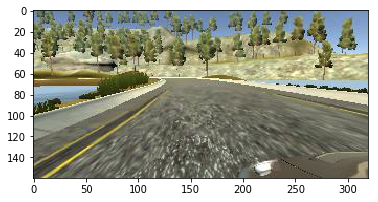

In [28]:
# visualizations

# load sample data
directory = SAMPLE_DATA
samples = []
with open(directory+'driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        # store center image driving data
        name = line[0].split('/')[-1]
        angle = float(line[3])
        flip = False

        samples.append(DrivingData(name, angle, flip, directory))

        # also store left and right images with corrected steering angles
        correction = STEERING_CORRECTION
        angle_left = angle + correction
        angle_right = angle - correction

        name_left = line[1].split('/')[-1]
        name_right = line[2].split('/')[-1]

        samples.append(DrivingData(name_left, angle_left, flip, directory))
        samples.append(DrivingData(name_right, angle_right, flip, directory))



idx = 1230
for counter in range(idx, idx+3):
    sample = samples[counter]
    current_path = sample.directory+'IMG/'+ sample.image
    image = cv2.imread(current_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image)
    plt.show()
    
# flip augmentation
for counter in range(idx, idx+3):
    sample = samples[counter]
    current_path = sample.directory+'IMG/'+ sample.image
    image = cv2.imread(current_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image, angle = flip_image(image, sample.angle)
    plt.imshow(image)
    plt.show()
    
